In [1]:
!git clone https://huggingface.co/datasets/cc92yy3344/vegetable.git

Cloning into 'vegetable'...
remote: Enumerating objects: 21083, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 21083 (delta 13), reused 26 (delta 10), pack-reused 21050
Receiving objects: 100% (21083/21083), 2.93 MiB | 3.27 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (21006/21006), done.
Filtering content: 100% (21000/21000), 545.26 MiB | 184.00 KiB/s, done.


In [8]:
import os

path = '/content/vegetable/Vegetable Images/train'
image_files = os.listdir(path)[:5]
image_list = []

for image_file in image_files:
    image_path = os.path.join(path, image_file)
    image_list.append(image_path)


Датасет представляет собой набор изображений овощей. Он содержит разнообразные фотографии овощей, снятых с различных ракурсов и в различных условиях освещения.

Задача, стоящая перед нами, заключается в классификации этих изображений овощей. Мы хотим создать модель, способную определить, к какому виду овощей относится каждое изображение.

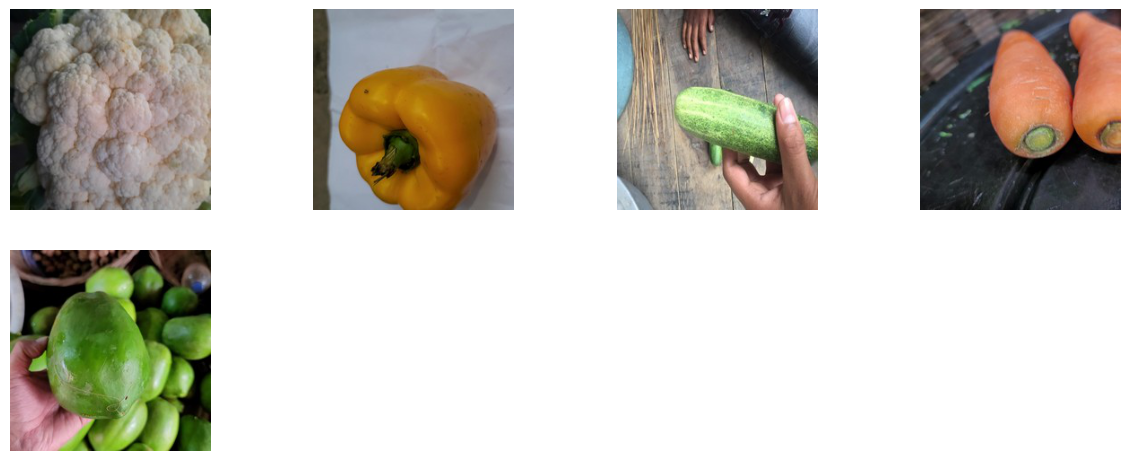

In [9]:
from PIL import Image
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))
i = 0
for folder in image_list:
    image_file = os.listdir(folder)
    image_path = os.path.join(folder, image_file[0])
    image = Image.open(image_path)
    ax = plt.subplot(4, 4, i + 1)
    plt.axis("off")
    plt.imshow(image)
    i += 1
    

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class VegetableDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes, self.class_to_idx = self.get_classes_and_class_to_idx()
        self.image_paths, self.labels = self.load_image_paths_and_labels()

    def get_classes_and_class_to_idx(self):
        classes = []
        class_to_idx = {}
        for _, class_name, file_names in os.walk(self.root_dir):
            for name in class_name:
                classes.append(name)
                class_to_idx[name] = len(class_to_idx)
        return classes, class_to_idx

    def load_image_paths_and_labels(self):
        image_paths = []
        labels = []
        for class_name in self.classes:
            class_dir = os.path.join(self.root_dir, class_name)
            for file_name in os.listdir(class_dir):
                if file_name.endswith(".jpg") or file_name.endswith(".png"):
                    image_paths.append(os.path.join(class_dir, file_name))
                    labels.append(self.class_to_idx[class_name])
        return image_paths, labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label
    
train_dir = "/content/vegetable/Vegetable Images/train"
test_dir = "/content/vegetable/Vegetable Images/test"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = VegetableDataset(train_dir, transform=transform)
test_dataset = VegetableDataset(test_dir, transform=transform)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [29]:
import torch.nn as nn
import torch.optim as optim

class MyNet(nn.Module):
    def __init__(self, num_classes):
        super(MyNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Linear(32 * 56 * 56, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

learning_rate = 0.001
num_epochs = 10
num_classes = 15

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MyNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(train_dataloader)

correct = 0
total = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if (i + 1) % 10 == 0:
            print(f"Эпоха [{epoch + 1}/{num_epochs}], Шаг [{i + 1}/{total_step}], Потеря: {loss.item():.4f}, Accuracy: {100 * correct/total:.2f}%")

print("Обучение завершено.")


Эпоха [1/10], Шаг [10/469], Потеря: 2.4226, Accuracy: 14.38%
Эпоха [1/10], Шаг [20/469], Потеря: 2.0765, Accuracy: 19.69%
Эпоха [1/10], Шаг [30/469], Потеря: 1.6856, Accuracy: 26.67%
Эпоха [1/10], Шаг [40/469], Потеря: 1.4455, Accuracy: 32.50%
Эпоха [1/10], Шаг [50/469], Потеря: 0.9551, Accuracy: 37.31%
Эпоха [1/10], Шаг [60/469], Потеря: 1.9723, Accuracy: 40.62%
Эпоха [1/10], Шаг [70/469], Потеря: 1.0653, Accuracy: 43.12%
Эпоха [1/10], Шаг [80/469], Потеря: 0.8998, Accuracy: 45.66%
Эпоха [1/10], Шаг [90/469], Потеря: 0.5777, Accuracy: 48.33%
Эпоха [1/10], Шаг [100/469], Потеря: 0.9388, Accuracy: 50.03%
Эпоха [1/10], Шаг [110/469], Потеря: 0.9598, Accuracy: 51.76%
Эпоха [1/10], Шаг [120/469], Потеря: 0.7184, Accuracy: 53.54%
Эпоха [1/10], Шаг [130/469], Потеря: 0.7290, Accuracy: 54.98%
Эпоха [1/10], Шаг [140/469], Потеря: 0.3971, Accuracy: 56.50%
Эпоха [1/10], Шаг [150/469], Потеря: 1.0365, Accuracy: 57.83%
Эпоха [1/10], Шаг [160/469], Потеря: 0.7781, Accuracy: 59.04%
Эпоха [1/10], Шаг

In [30]:
import torchvision.models as models

pretrained_model = models.resnet18(pretrained=True)
pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, num_classes)
pretrained_model = pretrained_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.parameters(), lr=learning_rate)

total_step = len(train_dataloader)

correct = 0
total = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = pretrained_model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if (i + 1) % 10 == 0:
            print(f"Эпоха [{epoch + 1}/{num_epochs}], Шаг [{i + 1}/{total_step}], Потеря: {loss.item():.4f}, Accuracy: {100 * correct/total:.2f}%")

print("Обучение с использованием Transfer Learning завершено.")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Эпоха [1/10], Шаг [10/469], Потеря: 0.4192, Accuracy: 71.56%
Эпоха [1/10], Шаг [20/469], Потеря: 0.4956, Accuracy: 77.34%
Эпоха [1/10], Шаг [30/469], Потеря: 0.2332, Accuracy: 81.98%
Эпоха [1/10], Шаг [40/469], Потеря: 0.2621, Accuracy: 83.91%
Эпоха [1/10], Шаг [50/469], Потеря: 1.0238, Accuracy: 84.75%
Эпоха [1/10], Шаг [60/469], Потеря: 0.1313, Accuracy: 85.47%
Эпоха [1/10], Шаг [70/469], Потеря: 0.8262, Accuracy: 86.16%
Эпоха [1/10], Шаг [80/469], Потеря: 0.2853, Accuracy: 86.33%
Эпоха [1/10], Шаг [90/469], Потеря: 0.3257, Accuracy: 86.53%
Эпоха [1/10], Шаг [100/469], Потеря: 0.2628, Accuracy: 86.69%
Эпоха [1/10], Шаг [110/469], Потеря: 0.1867, Accuracy: 87.36%
Эпоха [1/10], Шаг [120/469], Потеря: 0.4385, Accuracy: 87.84%
Эпоха [1/10], Шаг [130/469], Потеря: 0.2517, Accuracy: 88.03%
Эпоха [1/10], Шаг [140/469], Потеря: 0.2099, Accuracy: 88.37%
Эпоха [1/10], Шаг [150/469], Потеря: 0.1628, Accuracy: 88.81%
Эпоха [1/10], Шаг [160/469], Потеря: 0.1115, Accuracy: 89.06%
Эпоха [1/10], Шаг

In [31]:
pretrained_model.eval()

test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = pretrained_model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Loss: {test_loss / len(test_dataloader):.4f} | Test Accuracy: {100 * correct/total:.2f}%')

Test Loss: 0.0084 | Test Accuracy: 99.70%


In [32]:
model.eval()

test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Loss: {test_loss / len(test_dataloader):.4f} | Test Accuracy: {100 * correct/total:.2f}%')

Test Loss: 0.2986 | Test Accuracy: 94.47%
